# Parameter Selection with Preprocessing

Here’s code forsplitting the data, computing the minimum and maximum, scaling the data, and training the SVM:

In [3]:
from sklearn.datasets import load_breast_cancer
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.svm import SVC 

# load and split the data
cancer = load_breast_cancer()
X_train, X_test, y_train, y_test = train_test_split(cancer.data, cancer.target, random_state = 0)

# compute minimum and maximum on the training data
scaler = MinMaxScaler().fit(X_train)

# rescale the training data
X_train_scaled = scaler.transform(X_train)

svm = SVC()
# learn an SVM on the scaled training data
svm.fit(X_train_scaled, y_train)
# scale the test data and score the scaled data
X_test_scaled = scaler.transform(X_test)
print("Test score: {:.2f}".format ( svm . score ( X_test_scaled , y_test ))) 

Test score: 0.95


/Users/YoheiMiyamoto/anaconda3/lib/python3.7/site-packages/sklearn/svm/base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)


Now let’s say we want to find better parameters for SVC using GridSearchCV , as discussed in Chapter 5 . How should we go about doingthis? A naive approach might look like this:

In [4]:
from sklearn.model_selection import GridSearchCV

# for illustration purposes only, don't use this code!
param_grid = {'C' : [ 0.001 , 0.01 , 0.1 , 1 , 10 , 100 ], 'gamma': [ 0.001 , 0.01 , 0.1 , 1 , 10 , 100 ]}
grid = GridSearchCV(SVC(), param_grid = param_grid , cv = 5)
grid.fit(X_train_scaled, y_train)

print("Best cross-validation accuracy: {:.2f}".format(grid.best_score_))
print("Best parameters: ", grid.best_params_)
print("Test set accuracy: {:.2f}".format(grid.score(X_test_scaled, y_test))) 

Best cross-validation accuracy: 0.98
Best parameters:  {'C': 1, 'gamma': 1}
Test set accuracy: 0.97


To get around this problem, the splitting of the dataset duringcross-validation should be done before doing any preprocessing . Anyprocess that extracts knowledge from the dataset should only ever belearned from the training portion of the dataset, and therefore be containedinside the cross-validation loop.

In [5]:
from sklearn.pipeline import Pipeline
pipe = Pipeline([("scaler", MinMaxScaler()), ("svm", SVC())])

Here, we created two steps: the first, called "scaler" , is an instance ofMinMaxScaler , and the second, called "svm" , is an instance of SVC . Now, we can fitthe pipeline, like any other scikit-learn estimator:

Here, pipe.fit first calls fit on the first step (the scaler), then transforms the training data using the scaler, and finally fits the SVMwith the scaled data. To evaluate on the test data, we simply callpipe.score :

In [6]:
pipe.fit(X_train, y_train)

/Users/YoheiMiyamoto/anaconda3/lib/python3.7/site-packages/sklearn/svm/base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)


Pipeline(memory=None,
     steps=[('scaler', MinMaxScaler(copy=True, feature_range=(0, 1))), ('svm', SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma='auto_deprecated',
  kernel='rbf', max_iter=-1, probability=False, random_state=None,
  shrinking=True, tol=0.001, verbose=False))])

Calling the score method on the pipeline first transforms the testdata using the scaler, and then calls the score method on the SVMusing the scaled test data. As you can see, the result is identical tothe one we got from the code at the beginning of the chapter, when doing the transformations by hand.Using the pipeline, we reduced the code needed for our “preprocessing   classification” process. The main benefit of using the pipeline,however, is that we can now use this single estimator incross_val_score or GridSearchCV .

In [7]:
print("Test score: {:.2f}".format(pipe.score(X_test, y_test)))

Test score: 0.95


# Using Pipelines in Grid Searches

The syntaxto define a parameter grid for a pipeline is to specify for eachparameter the step name, followed by __ (a double underscore),followed by the parameter name. To search over the C parameter of SVC we therefore have to use "svm__C" as the key in the parametergrid dictionary, and similarly for gamma :

In [8]:
param_grid = { 'svm__C': [ 0.001 , 0.01 , 0.1 , 1 , 10 , 100 ], 'svm__gamma': [ 0.001 , 0.01 , 0.1 , 1 , 10 , 100 ]}

In [9]:
grid = GridSearchCV(pipe, param_grid = param_grid, cv = 5)
grid.fit(X_train, y_train)

print("Best cross-validation accuracy: {:.2f}".format(grid.best_score_))
print("Test set score: {:.2f}".format(grid.score(X_test, y_test)))
print("Best parameters: {}".format(grid.best_params_))

Best cross-validation accuracy: 0.98
Test set score: 0.97
Best parameters: {'svm__C': 1, 'svm__gamma': 1}


# Illustrating Information Leakage

Given the way we created the dataset, there is no relation between thedata, X , and the target, y (they are independent), so it should not be possible to learn anything from this dataset.

In [10]:
import numpy as np

rnd = np.random.RandomState(seed = 0)
X = rnd.normal(size = (100, 10000))
y = rnd.normal(size = (100,))

First, select the most informative of the 10,000 features using SelectPercentile feature selection, and then we evaluate a Ridge regressor using cross-validation:

In [11]:
from sklearn.feature_selection import SelectPercentile , f_regression

select = SelectPercentile(score_func = f_regression, percentile = 5).fit(X, y)
X_selected = select.transform(X)

print("X_selected.shape: {}".format(X_selected.shape))

X_selected.shape: (100, 500)


In [12]:
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import Ridge

print("Cross-validation accuracy (cv only on ridge): {:.2f}".format(np.mean(cross_val_score(Ridge(), X_selected, y, cv = 5))))

Cross-validation accuracy (cv only on ridge): 0.91


In [13]:
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import Ridge

print("Cross-validation accuracy (cv only on ridge): {:.2f}".format(np.mean(cross_val_score(Ridge(), X_selected, y, cv = 5)))) 

Cross-validation accuracy (cv only on ridge): 0.91


The mean R 2 computed by cross-validation is 0.91,indicating a very good model. This clearly cannot be right,

Because we fit the featureselection outside of the cross-validation, it could find features thatare correlated both on the training and the test folds. The informationwe leaked from the test folds was very informative, leading to highlyunrealistic results. Let’s compare this to a proper cross-validationusing a pipeline:

In [14]:
pipe = Pipeline([("select", SelectPercentile(score_func = f_regression, percentile = 5)), ("ridge", Ridge())])
print("Cross-validation accuracy (pipeline): {:.2f}".format(np.mean(cross_val_score(pipe, X, y, cv = 5)))) 

Cross-validation accuracy (pipeline): -0.25


# The General Pipeline Interface

The only requirement for estimators in a pipeline is that all but thelast step need to have a transform method, so they can produce a newrepresentation of the data that can be used in the next step. Internally, during the call to Pipeline.fit , the pipeline callsfit and then transform on each step in turn, 2 with the input given by the output of the transform method of the previous step. For the last step in the pipeline, justfit is called.

In [15]:
def fit(self, X, y):
    X_transformed = X
    for name, estimator in self.steps[: 1]:
        # iterate over all but the final step
        # fit and transform the data
        X_transformed = estimator.fit_transform(X_transformed, y)
    # fit the last step
    self.steps[1][1].fit(X_transformed, y)
    return self

In [16]:
def predict(self, X ):
    X_transformed = X
    for step in self.steps[: 1]:
        # iterate over all but the final step
        # transform the data
        X_transformed = step[1].transform(X_transformed)
    # predict using the last step
    return self.steps[1][1].predict(X_transformed) 

# Convenient Pipeline Creation with make_pipeline

There is a convenience function, make_pipeline , that will create apipeline for us and automatically name each step based on its class.

In [17]:
from sklearn.pipeline import make_pipeline

# standard syntax
pipe_long = Pipeline([("scaler", MinMaxScaler()), ("svm", SVC(C = 100))])
# abbreviated syntax
pipe_short = make_pipeline(MinMaxScaler(), SVC(C = 100))

The pipeline objects pipe_long and pipe_short do exactly the samething, but pipe_short has steps that were automatically named.We can see the names of the steps by looking at the steps attribute:

In [18]:
print("Pipeline steps: \n {}".format(pipe_short.steps))

Pipeline steps: 
 [('minmaxscaler', MinMaxScaler(copy=True, feature_range=(0, 1))), ('svc', SVC(C=100, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma='auto_deprecated',
  kernel='rbf', max_iter=-1, probability=False, random_state=None,
  shrinking=True, tol=0.001, verbose=False))]


In general, the step names are just lowercase versions of the class names. If multiple steps have
the same class, a number is appended:

In [19]:
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA 

pipe = make_pipeline(StandardScaler(), PCA(n_components = 2), StandardScaler())
print("Pipeline steps: \n {}".format(pipe.steps)) 

Pipeline steps: 
 [('standardscaler-1', StandardScaler(copy=True, with_mean=True, with_std=True)), ('pca', PCA(copy=True, iterated_power='auto', n_components=2, random_state=None,
  svd_solver='auto', tol=0.0, whiten=False)), ('standardscaler-2', StandardScaler(copy=True, with_mean=True, with_std=True))]


# Accessing Step Attributes

The easiest way to access the steps in a pipeline is viathe named_steps attribute, which is a dictionary from the step names tothe estimators:

In [20]:
from sklearn.datasets import load_breast_cancer

cancer = load_breast_cancer()

# fit the pipeline defined before to the cancer dataset
pipe.fit(cancer.data)
# extract the first two principal components from the "pca" step
components = pipe.named_steps["pca"].components_
print("components.shape: {}".format(components.shape)) 

components.shape: (2, 30)


# Accessing Attributes in a Pipeline inside GridSearchCV

As we discussed earlier in this chapter, one of the main reasons to use pipelines is fordoing grid searches.

In [21]:
from sklearn.linear_model import LogisticRegression

pipe = make_pipeline(StandardScaler(), LogisticRegression())

Because we used the make_pipeline function, the name of theLogisticRegression step in the pipeline is the lowercased class name,logisticregression . To tune the parameter C , we therefore have tospecify a parameter grid for logisticregression__C :

In [22]:
param_grid = { 'logisticregression__C' : [ 0.01 , 0.1 , 1 , 10 , 100 ]}

As usual, we split the cancer dataset into training and test sets, andfit a grid search:

In [23]:
X_train, X_test, y_train, y_test = train_test_split(cancer.data, cancer.target, random_state = 4)
grid = GridSearchCV(pipe, param_grid, cv = 5)
grid.fit(X_train, y_train) 

/Users/YoheiMiyamoto/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Users/YoheiMiyamoto/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Users/YoheiMiyamoto/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Users/YoheiMiyamoto/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Users/YoheiMiyamoto/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: 

GridSearchCV(cv=5, error_score='raise-deprecating',
       estimator=Pipeline(memory=None,
     steps=[('standardscaler', StandardScaler(copy=True, with_mean=True, with_std=True)), ('logisticregression', LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='warn',
          n_jobs=None, penalty='l2', random_state=None, solver='warn',
          tol=0.0001, verbose=0, warm_start=False))]),
       fit_params=None, iid='warn', n_jobs=None,
       param_grid={'logisticregression__C': [0.01, 0.1, 1, 10, 100]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=None, verbose=0)

From Chapter 5 we know that thebest model found by GridSearchCV , trained on all the training data, isstored in grid.best_estimator_ :

In [24]:
print("Best estimator: \n {}".format(grid.best_estimator_))

Best estimator: 
 Pipeline(memory=None,
     steps=[('standardscaler', StandardScaler(copy=True, with_mean=True, with_std=True)), ('logisticregression', LogisticRegression(C=0.1, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='warn',
          n_jobs=None, penalty='l2', random_state=None, solver='warn',
          tol=0.0001, verbose=0, warm_start=False))])


This best_estimator_ in our case is a pipeline with two steps,standardscaler and logisticregression . To access thelogisticregression step, we can use the named_steps attribute of thepipeline, as explained earlier:

In [25]:
print("Logistic regression step: \n {}".format(grid.best_estimator_.named_steps["logisticregression"]))

Logistic regression step: 
 LogisticRegression(C=0.1, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='warn',
          n_jobs=None, penalty='l2', random_state=None, solver='warn',
          tol=0.0001, verbose=0, warm_start=False)


Now that we have the trained LogisticRegression instance, we canaccess the coefficients (weights) associated with each input feature:

In [26]:
print("Logistic regression coefficients: \n {}".format(grid.best_estimator_.named_steps["logisticregression" ].coef_))

Logistic regression coefficients: 
 [[-0.38856355 -0.37529972 -0.37624793 -0.39649439 -0.11519359  0.01709608
  -0.3550729  -0.38995414 -0.05780518  0.20879795 -0.49487753 -0.0036321
  -0.37122718 -0.38337777 -0.04488715  0.19752816  0.00424822 -0.04857196
   0.21023226  0.22444999 -0.54669761 -0.52542026 -0.49881157 -0.51451071
  -0.39256847 -0.12293451 -0.38827425 -0.4169485  -0.32533663 -0.13926972]]


# Grid-Searching Preprocessing Steps and Model Parameters

Using pipelines, we can encapsulate all the processing steps in our machinelearning workflow in a single scikit-learn estimator. Another benefitof doing this is that we can now adjust the parameters of thepreprocessing using the outcome of a supervised task like regression orclassification. In previous chapters, we used polynomial features on theboston dataset before applying the ridge regressor. Let’s model thatusing a pipeline instead. The pipeline contains three steps scaling thedata, computing polynomial features, and ridge regression:

In [28]:
from sklearn.datasets import load_boston

boston = load_boston ()
X_train, X_test, y_train, y_test = train_test_split(boston.data, boston.target, random_state = 0)

from sklearn.preprocessing import PolynomialFeatures

pipe = make_pipeline(StandardScaler(), PolynomialFeatures(), Ridge())

How do we know which degrees of polynomials to choose, or whether tochoose any polynomials or interactions at all? Ideally we want to selectthe degree parameter based on the outcome of the classification. Usingour pipeline, we can search over the degree parameter together withthe parameter alpha of Ridge . To do this, we define a param_grid that contains both, appropriately prefixed by the step names:

In [29]:
param_grid = { 'polynomialfeatures__degree': [1, 2, 3], 'ridge__alpha': [0.001, 0.01, 0.1, 1, 10, 100]}
grid = GridSearchCV(pipe, param_grid = param_grid, cv = 5, n_jobs = -1)
grid.fit(X_train, y_train)

/Users/YoheiMiyamoto/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


GridSearchCV(cv=5, error_score='raise-deprecating',
       estimator=Pipeline(memory=None,
     steps=[('standardscaler', StandardScaler(copy=True, with_mean=True, with_std=True)), ('polynomialfeatures', PolynomialFeatures(degree=2, include_bias=True, interaction_only=False)), ('ridge', Ridge(alpha=1.0, copy_X=True, fit_intercept=True, max_iter=None,
   normalize=False, random_state=None, solver='auto', tol=0.001))]),
       fit_params=None, iid='warn', n_jobs=-1,
       param_grid={'polynomialfeatures__degree': [1, 2, 3], 'ridge__alpha': [0.001, 0.01, 0.1, 1, 10, 100]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=None, verbose=0)

Looking at the results produced by the cross-validation, we can see thatusing polynomials of degree two helps, but that degree-three polynomialsare much worse than either degree one or two. This is reflected in thebest parameters that were found:

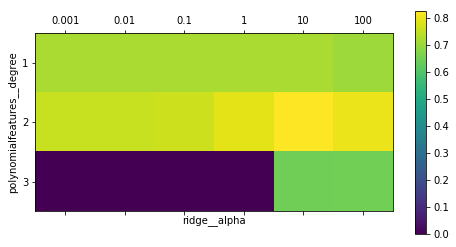

In [33]:
import matplotlib.pyplot as plt

plt.matshow(grid.cv_results_['mean_test_score'].reshape(3, -1), vmin = 0, cmap = "viridis")
plt.xlabel("ridge__alpha")
plt.ylabel("polynomialfeatures__degree")
plt.xticks(range(len(param_grid['ridge__alpha'])), param_grid['ridge__alpha'])
plt.yticks(range(len(param_grid['polynomialfeatures__degree'])), param_grid['polynomialfeatures__degree'])
plt.colorbar()

In [35]:
print("Best parameters: {}".format(grid.best_params_))
print("Test-set score: {:.2f}".format(grid.score(X_test, y_test)))

Best parameters: {'polynomialfeatures__degree': 2, 'ridge__alpha': 10}
Test-set score: 0.77


Let’s run a grid search without polynomial features for comparison:

In [36]:
param_grid = {'ridge__alpha' : [ 0.001 , 0.01 , 0.1 , 1 , 10 , 100 ]}
pipe = make_pipeline(StandardScaler(), Ridge())
grid = GridSearchCV(pipe, param_grid, cv = 5)
grid.fit(X_train, y_train)
print("Score without poly features: {:.2f}".format(grid.score(X_test, y_test))) 

Score without poly features: 0.63


/Users/YoheiMiyamoto/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


# Grid-Searching Which Model To Use

In [37]:
pipe = Pipeline([('preprocessing', StandardScaler ()), ('classifier', SVC())])

When we wanted to skip a step in thepipeline (for example, because we don’t need preprocessing for theRandomForest ), we can set that step to None :

In [39]:
from sklearn.ensemble import RandomForestClassifier

param_grid = [
    {
        'classifier': [ SVC ()],
        'preprocessing': [ StandardScaler (), None ],
        'classifier__gamma' : [ 0.001 , 0.01 , 0.1 , 1 , 10 , 100 ],
        'classifier__C' : [ 0.001 , 0.01 , 0.1 , 1 , 10 , 100 ]
    },
    {
        'classifier' : [ RandomForestClassifier ( n_estimators = 100 )],
        'preprocessing' : [ None ],
        'classifier__max_features' : [ 1 , 2 , 3 ]
    }
]

Now we can instantiate and run the grid search as usual, here on thecancer dataset:

The outcome of the grid search is that SVC with StandardScaler preprocessing, C=10 , and gamma=0.01 gave the best result.

In [40]:
X_train, X_test, y_train, y_test = train_test_split(cancer.data, cancer.target, random_state = 0)
grid = GridSearchCV(pipe, param_grid, cv = 5)
grid.fit(X_train, y_train)
print("Best params: \n {} \n ".format(grid.best_params_))
print("Best cross-validation score: {:.2f}".format(grid.best_score_))
print("Test-set score: {:.2f}".format(grid.score(X_test, y_test)))

Best params: 
 {'classifier': SVC(C=10, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma=0.01, kernel='rbf',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False), 'classifier__C': 10, 'classifier__gamma': 0.01, 'preprocessing': StandardScaler(copy=True, with_mean=True, with_std=True)} 
 
Best cross-validation score: 0.99
Test-set score: 0.98


# Avoiding Redundant Computation

When performing a large grid-search like the ones described earlier,the same steps are often used several times.

This can be done with the memory parameter of Pipeline , which takes a joblib.Memory object or justa path to store the cache.

In [ ]:
pipe = Pipeline([('preprocessing', StandardScaler ()), ('classifier', SVC())], memory = "cache_folder")